In [1]:
!echo $PATH

/usr/bin:/home/open/.vscode-server/bin/6261075646f055b99068d3688932416f2346dd3b/bin/remote-cli:/home/open/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [1]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# pd.read_csv("./nodelist.csv")

# For Variable Number of SFC Requests

In [3]:
num_edges = 21
num_nodes = 14
oper_costs = range(5,11)
num_cnfNumber = 4
end_delays = range(30,51)
cpu_bounds = range(10,15+1)           #(4,6+1)
bandwidth_bounds = range(4,6+1)
# cpu utilizaion of one sfc request with total number of sfc requsts indexed with 0 (With 4 cnf in one sfc request)
cnfCPU = {1 : 14.32 , 2 : 15.25, 3 : 13.87, 4 : 13.27, 0: 14}
EdgeList=[(0, 1), (1, 2), (0, 3), (0, 2), (1, 7), (2, 5), (3, 4), (3, 10), (4, 5), (4, 6), (5, 9),
          (5, 12), (6, 7), (7, 8), (8, 11), (8, 13), (8, 9), (10, 11), (10, 13), (11, 12), (12, 13)]
L = {
    (0,1):1,
    (1,2):3,
    (0,3):3,
    (0,2): 2,
    (1,7): 7,
    (2,5): 4,
    (3,4): 3,
    (3,10): 8,
    (4,5): 0,
    (4,6): 2,
    (5,9): 6,
    (5,12): 8,
    (6,7): 2,
    (7,8): 2,
    (8,11): 5,
    (8,13): 5,
    (8,9): 6,
    (10,11): 4,
    (10,13): 6,
    (11,12): 6,
    (12,13): 1
}

init_cpu = 100
init_bandwidth = 100

In [7]:
num_sfcRequests = 65+1
max_num_sfc_req = num_sfcRequests
init_operationalCost = [ random.choice(oper_costs) for i in range(num_nodes)]
# init_operationalCost = [10, 5, 8, 5, 6, 8, 10, 6, 9, 5, 7, 8, 5, 9]
init_endDelay = [random.choice(end_delays) for i in range(num_sfcRequests)]
init_bandwidthReq = [random.choice(bandwidth_bounds) for i in range(num_sfcRequests)]

init_cpuReq = {}
for i in range(num_sfcRequests):
    for j in range(num_cnfNumber):
        try:
            init_cpuReq[i,j] = cnfCPU[j]/3
        except:
            init_cpuReq[i,j] = random.choice(cpu_bounds)/3

init_endDelays = init_endDelay
init_bandwidthReqs = init_bandwidthReq 
init_cpuReqs = init_cpuReq
OperationalCosts = {}
CpuUtilization = {}


for num_sfcRequests in reversed(range(1,max_num_sfc_req)):
    init_endDelay = init_endDelays[0:num_sfcRequests]
    init_bandwidthReq = init_bandwidthReqs[0:num_sfcRequests]
    init_cpuReq = {}
    for i in range(num_sfcRequests):
        for j in range(num_cnfNumber):
            init_cpuReq[i,j] = init_cpuReqs[i,j]
    model = pyo.ConcreteModel()

    model.set_cnfNumber = pyo.RangeSet(0,num_cnfNumber-1) # j {0,1,2,3,4}
    model.set_sfcRequests = pyo.RangeSet(0,num_sfcRequests-1) # i {0,1,2} 

    # 14 nodes and 21 edges - NSFNET
    model.set_nodes = pyo.RangeSet(0,num_nodes-1) # v (0,1,...,13)
    model.set_edges = pyo.RangeSet(0,num_edges-1) # (u,v) (0,1,...,21)

    # Variables and Parameters

    # L - to be done

    model.y = pyo.Var(model.set_sfcRequests, model.set_cnfNumber,model.set_nodes,domain=pyo.Binary)

    model.z = pyo.Var(model.set_sfcRequests, model.set_edges, domain=pyo.Binary)

    model.C = pyo.Param(model.set_nodes, initialize=init_cpu)

    model.B = pyo.Param(model.set_edges, initialize=init_bandwidth)

    model.W = pyo.Param(model.set_nodes, initialize=init_operationalCost)

    model.l = pyo.Param(model.set_sfcRequests, initialize=init_endDelay)

    model.c = pyo.Param(model.set_sfcRequests, model.set_cnfNumber, initialize=init_cpuReq)

    model.b = pyo.Param(model.set_sfcRequests, initialize=init_bandwidthReq)

    y = model.y
    z = model.z
    C = model.C
    B = model.B
    W = model.W
    l = model.l
    c = model.c
    b = model.b

    # Constraints

    model.cpuConstraint = pyo.ConstraintList()
    for v in range(num_nodes):
         model.cpuConstraint.add(
             expr=sum(sum(y[i,j,v]*c[i,j] for j in range(num_cnfNumber)) for i in range(num_sfcRequests)) <= C[v]
         )

    model.bandwidthConstraint = pyo.ConstraintList()
    for _,e in enumerate(EdgeList):
        model.bandwidthConstraint.add(
            expr=sum(z[i,_]*b[i] for i in range(num_sfcRequests)) <= B[_]
        )

    model.delayConstraint = pyo.ConstraintList()
    # for _,e in enumerate(EdgeList):
    for i in range(num_sfcRequests):
        model.delayConstraint.add(
            expr=sum(z[i,_]*L[EdgeList[_][0],EdgeList[_][1]] for _ in range(num_edges)) <= l[i]
        )
        
    model.placementConstraint = pyo.ConstraintList()
    for i in range(num_sfcRequests):
        for j in range(num_cnfNumber):
            model.placementConstraint.add(
                expr=sum(y[i,j,v] for v in range(num_nodes)) == 1
            )


    # Objective Function

    model.objective = pyo.Objective(
        expr=sum(
                sum(
                    sum(y[i,j,v]*c[i,j]*W[v] for v in range(num_nodes))
                    for j in range(num_cnfNumber)
                )
            for i in range(num_sfcRequests)
        ), sense=minimize
    )

    # Solving the Model using IBM Cplex

    optimizer = SolverFactory('cplex',executable="/home/open/ibm/ILOG/CPLEX_Studio221/cplex/bin/x86-64_linux/cplex")

    optimizer.solve(model)

    # Printing the outputs

    Oper_cost = sum(
                    sum(
                        sum(y[i,j,v]*c[i,j]*W[v] for v in range(num_nodes))
                        for j in range(num_cnfNumber)
                    )
                for i in range(num_sfcRequests)
        )


    Cpu_util = sum(
                    sum(
                        sum(y[i,j,v]*c[i,j] for v in range(num_nodes))
                        for j in range(num_cnfNumber)
                    )
                for i in range(num_sfcRequests)
        )

    print("Operational Cost of the current setting: ",pyo.value(Oper_cost))
    OperationalCosts[num_sfcRequests] = pyo.value(Oper_cost)
    CpuUtilization[num_sfcRequests] = pyo.value(Cpu_util)
    
    print("================== ",num_sfcRequests," =================")
    # for i in range(num_sfcRequests):
    #     for e in range(num_edges):
    #         if(pyo.value(z[i,e])):
    #             print(i,e)
    # for i in range(num_sfcRequests):
    #     for j in range(num_cnfNumber):
    #         for v in range(num_nodes):
    #             if(pyo.value(y[i,j,v])):
    #                 print(i,j,v)

In [34]:
# for i in range(max_num_sfc_req):
#     for e in range(num_edges):
#         if(pyo.value(z[i,e])):
#             print(i,e)

In [35]:
CpuUtilization

{60: 1148.7999999999984,
 59: 1129.6533333333318,
 58: 1110.5066666666653,
 57: 1091.3599999999988,
 56: 1072.2133333333322,
 55: 1053.0666666666657,
 54: 1033.9199999999992,
 53: 1014.7733333333326,
 52: 995.626666666666,
 51: 976.4799999999993,
 50: 957.3333333333327,
 49: 938.186666666666,
 48: 919.0399999999994,
 47: 899.8933333333327,
 46: 880.7466666666661,
 45: 861.5999999999995,
 44: 842.4533333333328,
 43: 823.3066666666662,
 42: 804.1599999999995,
 41: 785.0133333333329,
 40: 765.8666666666662,
 39: 746.7199999999996,
 38: 727.5733333333329,
 37: 708.4266666666663,
 36: 689.2799999999996,
 35: 670.133333333333,
 34: 650.9866666666663,
 33: 631.8399999999997,
 32: 612.693333333333,
 31: 593.5466666666664,
 30: 574.3999999999997,
 29: 555.2533333333331,
 28: 536.1066666666665,
 27: 516.9599999999998,
 26: 497.81333333333316,
 25: 478.6666666666665,
 24: 459.51999999999987,
 23: 440.3733333333332,
 22: 421.2266666666666,
 21: 402.0799999999999,
 20: 382.9333333333333,
 19: 363.7

In [7]:
OperationalCosts

{40: 3120.9550000000036,
 39: 3020.5500000000034,
 38: 2920.0300000000025,
 37: 2819.5025000000032,
 36: 2719.2150000000033,
 35: 2619.305000000003,
 34: 2529.557500000003,
 33: 2443.462500000003,
 32: 2357.2825000000025,
 31: 2271.1375000000025,
 30: 2185.2075000000023,
 29: 2099.537500000002,
 28: 2013.867500000002,
 27: 1938.600000000002,
 26: 1866.8000000000018,
 25: 1795.0000000000016,
 24: 1723.2000000000014,
 23: 1651.4000000000012,
 22: 1579.600000000001,
 21: 1507.8000000000009,
 20: 1436.0000000000007,
 19: 1364.2000000000005,
 18: 1292.4000000000003,
 17: 1220.6000000000001,
 16: 1148.8,
 15: 1076.9999999999998,
 14: 1005.1999999999996,
 13: 933.3999999999996,
 12: 861.5999999999997,
 11: 789.7999999999997,
 10: 717.9999999999998,
 9: 646.1999999999998,
 8: 574.3999999999999,
 7: 502.59999999999985,
 6: 430.7999999999999,
 5: 358.99999999999994,
 4: 287.2,
 3: 215.4,
 2: 143.6,
 1: 71.8}

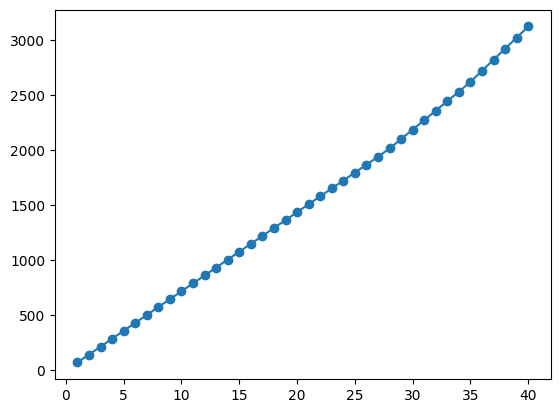

In [8]:
plt.plot(OperationalCosts.keys(),OperationalCosts.values(),'-o')

In [9]:
plt.show()

In [10]:
import pandas as pd
import time

In [11]:
model.pprint()

7 Set Declarations
    bandwidthConstraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   21 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
    c_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                        : Size : Members
        None :     2 : set_sfcRequests*set_cnfNumber :    4 : {(0, 0), (0, 1), (0, 2), (0, 3)}
    cpuConstraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
    delayConstraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    1 :    {1,}
    placementConstraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}
    y_inde

In [12]:
def getOperationalCosts():
    num_sfcRequests = 40+1
    max_num_sfc_req = num_sfcRequests
    init_operationalCost = [ random.choice(oper_costs) for i in range(num_nodes)]
    # init_operationalCost = [10, 5, 8, 5, 6, 8, 10, 6, 9, 5, 7, 8, 5, 9]
    init_endDelay = [random.choice(end_delays) for i in range(num_sfcRequests)]
    init_bandwidthReq = [random.choice(bandwidth_bounds) for i in range(num_sfcRequests)]

    init_cpuReq = {}
    for i in range(num_sfcRequests):
        for j in range(num_cnfNumber):
            try:
                init_cpuReq[i,j] = cnfCPU[j]/4
            except:
                init_cpuReq[i,j] = random.choice(cpu_bounds)/4

    init_endDelays = init_endDelay
    init_bandwidthReqs = init_bandwidthReq 
    init_cpuReqs = init_cpuReq
    OperationalCosts = {}


    for num_sfcRequests in reversed(range(1,max_num_sfc_req)):
        init_endDelay = init_endDelays[0:num_sfcRequests]
        init_bandwidthReq = init_bandwidthReqs[0:num_sfcRequests]
        init_cpuReq = {}
        for i in range(num_sfcRequests):
            for j in range(num_cnfNumber):
                init_cpuReq[i,j] = init_cpuReqs[i,j]
        model = pyo.ConcreteModel()

        model.set_cnfNumber = pyo.RangeSet(0,num_cnfNumber-1) # j {0,1,2,3,4}
        model.set_sfcRequests = pyo.RangeSet(0,num_sfcRequests-1) # i {0,1,2} 

        # 14 nodes and 21 edges - NSFNET
        model.set_nodes = pyo.RangeSet(0,num_nodes-1) # v (0,1,...,13)
        model.set_edges = pyo.RangeSet(0,num_edges-1) # (u,v) (0,1,...,21)

        # Variables and Parameters

        # L - to be done

        model.y = pyo.Var(model.set_sfcRequests, model.set_cnfNumber,model.set_nodes,domain=pyo.Binary)

        model.z = pyo.Var(model.set_sfcRequests, model.set_edges, domain=pyo.Binary)

        model.C = pyo.Param(model.set_nodes, initialize=init_cpu)

        model.B = pyo.Param(model.set_edges, initialize=init_bandwidth)

        model.W = pyo.Param(model.set_nodes, initialize=init_operationalCost)

        model.l = pyo.Param(model.set_sfcRequests, initialize=init_endDelay)

        model.c = pyo.Param(model.set_sfcRequests, model.set_cnfNumber, initialize=init_cpuReq)

        model.b = pyo.Param(model.set_sfcRequests, initialize=init_bandwidthReq)

        y = model.y
        z = model.z
        C = model.C
        B = model.B
        W = model.W
        l = model.l
        c = model.c
        b = model.b

        # Constraints

        model.cpuConstraint = pyo.ConstraintList()
        for v in range(num_nodes):
             model.cpuConstraint.add(
                 expr=sum(sum(y[i,j,v]*c[i,j] for j in range(num_cnfNumber)) for i in range(num_sfcRequests)) <= C[v]
             )

        model.bandwidthConstraint = pyo.ConstraintList()
        for _,e in enumerate(EdgeList):
            model.bandwidthConstraint.add(
                expr=sum(z[i,_]*b[i] for i in range(num_sfcRequests)) <= B[_]
            )

        model.delayConstraint = pyo.ConstraintList()
        # for _,e in enumerate(EdgeList):
        for i in range(num_sfcRequests):
            model.delayConstraint.add(
                expr=sum(z[i,_]*L[EdgeList[_][0],EdgeList[_][1]] for _ in range(num_edges)) <= l[i]
            )

        model.placementConstraint = pyo.ConstraintList()
        for i in range(num_sfcRequests):
            for j in range(num_cnfNumber):
                model.placementConstraint.add(
                    expr=sum(y[i,j,v] for v in range(num_nodes)) == 1
                )

        # Objective Function

        model.objective = pyo.Objective(
            expr=sum(
                    sum(
                        sum(y[i,j,v]*c[i,j]*W[v] for v in range(num_nodes))
                        for j in range(num_cnfNumber)
                    )
                for i in range(num_sfcRequests)
            ), sense=minimize
        )

        # Solving the Model using IBM Cplex

        optimizer = SolverFactory('cplex',executable="/home/open/ibm/ILOG/CPLEX_Studio221/cplex/bin/x86-64_linux/cplex")

        optimizer.solve(model)

        # Printing the outputs

        Oper_cost = sum(
                        sum(
                            sum(y[i,j,v]*c[i,j]*W[v] for v in range(num_nodes))
                            for j in range(num_cnfNumber)
                        )
                    for i in range(num_sfcRequests)
            )

        # print("Operational Cost of the current setting: ",pyo.value(Oper_cost))
        OperationalCosts[num_sfcRequests] = pyo.value(Oper_cost)


        # print("================== ",num_sfcRequests," =================")
    return OperationalCosts
        
    '''
        for i in range(num_sfcRequests):
            for j in range(num_cnfNumber):
                for v in range(num_nodes):
                    if(pyo.value(y[i,j,v])):
                        print(i,j,v)
    '''

In [13]:
trials = pd.DataFrame(OperationalCosts, index=[1])

In [14]:
trials

,40,39,38,37,36,35,34,33,32,31,...,10,9,8,7,6,5,4,3,2,1
1,3120.955,3020.55,2920.03,2819.5025,2719.215,2619.305,2529.5575,2443.4625,2357.2825,2271.1375,...,718.0,646.2,574.4,502.6,430.8,359.0,287.2,215.4,143.6,71.8


In [18]:
for i in range(1,10):
    strt = time.time()
    trials=trials.append(getOperationalCosts(),ignore_index=True)
    print("============",i,"============", time.time()-strt)

/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 1 ============ 15.730183839797974
============ 2 ============ 8.616764068603516


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 3 ============ 63.795016288757324


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 4 ============ 32.46563100814819


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 5 ============ 10.866160154342651


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 6 ============ 17.849395036697388


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


============ 7 ============ 20.749515771865845


/tmp/ipykernel_1009835/2291709197.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trials=trials.append(getOperationalCosts(),ignore_index=True)


KeyboardInterrupt: 

In [ ]:
# for i in range(1,99):
#     time.sleep(14)
#     strt = time.time()
#     trials=trials.append(getOperationalCosts(),ignore_index=True)
#     print("============",i,"============", time.time()-strt)

In [19]:
trials.to_csv("operational_costs_NSFNET.csv")